In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Training Data Preparation

Training data has 346 rows (data samples) and 17 columns (16 input features, minus the first 'Outcome' column).

Next workings:
- Split the dataset into X_train and Y_train. 

- Scale data.

- Convert data into numpy array.

- LabelEncoder on y_train.

- Convert into pytorch tensors.

- Create DataLoader. (create a batch by extracting a slice from the dataset)

In [2]:
# Loading training data into pandas dataframe
training_data = pd.read_csv('Fetus_trainingdata.csv')

# Split training data into X_train and y_train
X_train = training_data.drop('Outcome', axis=1)
y_train = training_data['Outcome']

# Scaling training data using sklearn StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Label encoder y_train 
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Convert data into torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Create DataLoader
train_dataset = list(zip(X_train, y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Testing Data Preparation

In [3]:
# Loading training data into pandas dataframe
testing_data = pd.read_csv('Fetus_testingdata.csv')

# Split training data into X_train and y_train
X_test = testing_data.drop('Outcome', axis=1)
y_test = testing_data['Outcome']

# Scaling training data using sklearn StandardScaler
# scaler = StandardScaler()
X_test = scaler.transform(X_test)

# Label encoder y_test 
# le = LabelEncoder()
y_test = le.transform(y_test)

# Convert data into torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
test_dataset = list(zip(X_test, y_test))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Preparing MLP

In [ ]:
# Two layer neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(16, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 5)    # Changed 5 hidden units to 10 hidden units
        # self.softmax = nn.Softmax(dim=1)    # Applies across classes

    # Feedforward
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)    # raw logits
        # x = self.softmax(x)

        return logits

### Training the model

Binary Cross Entropy Loss

- y_pred: predicted probabilities, y_true: true labels (0 or 1)

- nn.CrossEntropyLoss expects raw logits → do not apply Softmax before it.

- During inference, if you want probabilities, then you can use torch.softmax(logits, dim=1).

- Model remains simpler and numerically stable.

In [5]:
# Initialize model
model = MyNet()

# Loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer (Stochastic Gradient Descent - SGD)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Initialize learning rate scheduler 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train the net
epochs = 50
loss_per_iter = []
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
lrs = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    num_errors_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        logits = model(X_batch)    # forward pass
        loss = criterion(logits, y_batch)      
        loss.backward()
        optimizer.step()

        # Save loss to plot
        train_loss += loss.item()
        loss_per_iter.append(loss.item())

        # Compute training accuracy
        preds = torch.argmax(logits, dim=1)
        num_errors_train += (preds != y_batch).sum().item()
        total_train += y_batch.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * (1 - num_errors_train / total_train)


    # Validation
    model.eval()
    test_loss = 0.0
    num_errors_test = 0
    total_test = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            logits = model(X_test)
            loss = criterion(logits, y_test)
            test_loss += loss.item()

            probs = torch.softmax(logits, dim=1)    # convert logits -> probabilities
            preds = torch.argmax(probs, dim=1)
            total_test += y_test.size(0)      # Keeping track how many samples have been processed
            num_errors_test += (preds != y_test).sum().item()     # Count misclassified
    
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
    
    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * (1 - num_errors_test / total_test)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Training Loss: {avg_train_loss:.4f} | "
          f"Training Accuracy: {train_acc:.2f}% | "
          f"Testing Loss: {avg_test_loss:.4f} | "
          f"Testing Accuracy: {test_acc:.2f}%")


Epoch [1/50] Training Loss: 1.4383 | Training Accuracy: 37.28% | Testing Loss: 1.1815 | Testing Accuracy: 60.34%
Epoch [2/50] Training Loss: 1.0867 | Training Accuracy: 52.02% | Testing Loss: 0.9326 | Testing Accuracy: 70.69%
Epoch [3/50] Training Loss: 0.9130 | Training Accuracy: 58.96% | Testing Loss: 0.7970 | Testing Accuracy: 75.86%
Epoch [4/50] Training Loss: 0.8187 | Training Accuracy: 60.40% | Testing Loss: 0.7144 | Testing Accuracy: 75.86%
Epoch [5/50] Training Loss: 0.7604 | Training Accuracy: 58.96% | Testing Loss: 0.6747 | Testing Accuracy: 77.59%
Epoch [6/50] Training Loss: 0.7198 | Training Accuracy: 61.85% | Testing Loss: 0.6478 | Testing Accuracy: 79.31%
Epoch [7/50] Training Loss: 0.6977 | Training Accuracy: 64.45% | Testing Loss: 0.6120 | Testing Accuracy: 77.59%
Epoch [8/50] Training Loss: 0.6712 | Training Accuracy: 64.74% | Testing Loss: 0.5966 | Testing Accuracy: 77.59%
Epoch [9/50] Training Loss: 0.6527 | Training Accuracy: 66.47% | Testing Loss: 0.5761 | Testing 

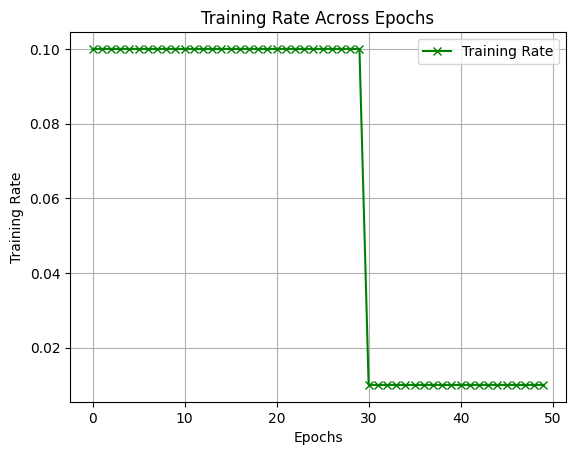

In [6]:
# Plotting learning rate across epochs
plt.plot(lrs, label='Training Rate', marker='x', color='green')
plt.xlabel('Epochs')
plt.ylabel("Training Rate")
plt.title('Training Rate Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

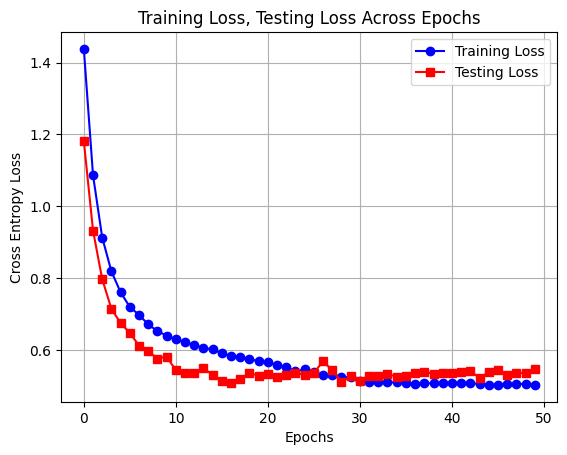

In [7]:
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(test_losses, label='Testing Loss', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss, Testing Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

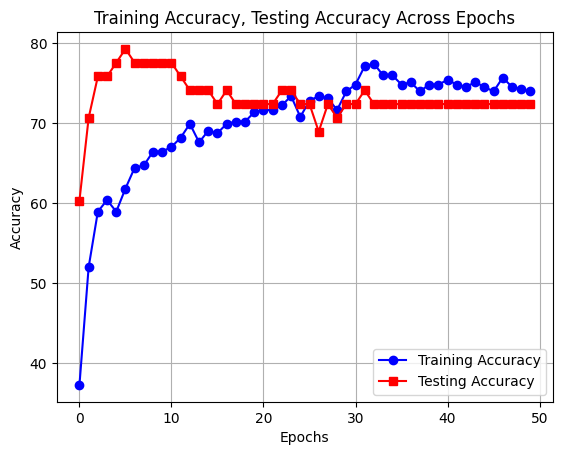

In [8]:
plt.plot(train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(test_accuracy, label='Testing Accuracy', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy, Testing Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

Next workings:

- Introduces regularization. (To prevent overfitting)
- Get the best hyperparameters, parameters


**Regularization**

- l1 , l2 regularizations
- Early stopping (Cross Validation)
- Batch normalization

In [ ]:
# Plotting training vs. testting error to learn model complexity
